# Import Package

In [8]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile,UnidentifiedImageError, ImageEnhance,ImageOps
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import random
import torch
import seaborn as sns
import pickle
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# STEP 1:  Problem Understanding 

- Bài toán: Nhận diện ký hiệu cơ thể chuyển sang ngôn ngữ đọc nói từ ảnh và video có sẵn.

- Loại bài toán: Phân loại ký hiệu tay, xử lý chuỗi văn bản, chuyển văn bản sang giọng nói .

- Đầu vào:  Các ảnh và video bàn tay và cơ thể người đang thưc hiện các ký hiệu.

- Output : (target) đưa ra văn bản và giọng nói sau khi đã nhận diện được chuỗi hành dộng.

- Mục tiêu: Giúp người khiếm thính và người khiếm thị có thể giao tiếp tốt với mọi người xung quanh.

# STEP 2: Data Understanding.

Mục đích: Hiểu rõ chất lượng đặc điểm và tiền xử lý dữ liệu ảnh

Bao gồm 
- Inconsistent: Tìm dữ liệu không nhất quán
- Data Overview: Kiểm tra tổng quan dữ liệu( số lượng ảnh và kích thước phổ biến)
- Imbalanced: Kiểm tra sự mất cân bằng giữa các lớp ( A, B, C, ...)
- Data Augmentation : Tăng cường dữ liệu 

In [9]:
# 2.1 Tìm dữ liệu không nhất quán 
dataset_path="../dataset"

# duyệt từng tệp trong từng thư mục con của dataset

for person in os.listdir(dataset_path): 
    person_path = os.path.join(dataset_path, person)
    for img_file in os.listdir(person_path):
        img_path = os.path.join(person_path, img_file)
        try:
            with Image.open(img_path) as img:
                img.verify()  # hàm xác minh ảnh
        except (UnidentifiedImageError, OSError):
            print(f"Ảnh lỗi: {img_path} \n Thực hiện xóa...")
            os.remove(img_path)  

In [10]:
# 2.2 kiểm tra số lượng ảnh và kích thước phổ biến
sizes = []
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    for img_file in os.listdir(person_path):
        img_path = os.path.join(person_path, img_file)
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
        except:
            pass  # Bỏ qua ảnh lỗi đã phát hiện ở trên

print("Số lượng ảnh:", len(sizes))
print("Kích thước phổ biến nhất:", max(set(sizes), key=sizes.count))

Số lượng ảnh: 4181
Kích thước phổ biến nhất: (225, 360)


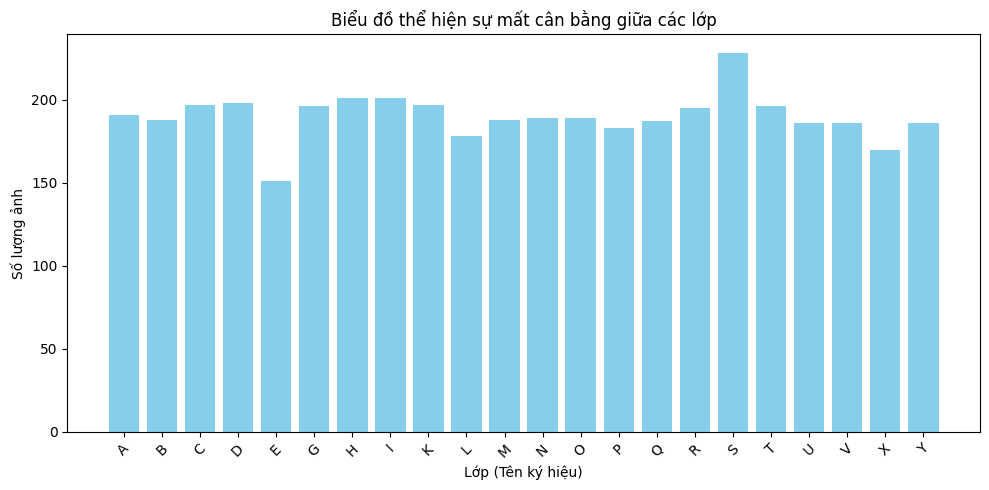

In [11]:
# 2.3 Kiểm tra sự mất cân bằng giữa các lớp

class_counts = defaultdict(int)

# Đếm số lượng ảnh của mỗi lớp
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if os.path.isdir(person_path):
        for img_file in os.listdir(person_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                class_counts[person] += 1

# Vẽ biểu đồ cột
labels = list(class_counts.keys())
values = list(class_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Lớp (Tên ký hiệu)")
plt.ylabel("Số lượng ảnh")
plt.title("Biểu đồ thể hiện sự mất cân bằng giữa các lớp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# 2.4 Tăng cường dữ liệu
# nếu người nào có số lượng ảnh dưới 60 thì tăng cường bằng các pp tcdl

min_images = 230 
def augment_image(img): # Các phương pháp tăng cường dữ liệu
    operations = [
        lambda x: x.rotate(15), # xoay phải 1 góc 15 độ
        lambda x: x.rotate(-15),# xoay trái 1 góc 15 độ
        lambda x: x.rotate(10), # xoay phải 10 độ
        lambda x: x.rotate(-10),# xoay trái 10 độ
        lambda x: ImageOps.mirror(x), # lật ngang
        lambda x: ImageEnhance.Brightness(x).enhance(1.5), # tăng độ sáng
        lambda x: ImageEnhance.Color(x).enhance(1.5), # tăng độ bão hòa
    ]
    op = random.choice(operations)
    return op(img)

for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue

    # Đếm số ảnh hiện có
    imgs = [f for f in os.listdir(person_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    count = len(imgs)
    print(f"{person} hiện có {count} ảnh.")
    if count >= min_images:
        continue  # Không cần tăng cường
    # Tạo thêm ảnh để đủ min_images
    needed = min_images - count
    print(f"Tăng cường thêm {needed} ảnh cho lớp {person}.")

    for i in range(needed):
        # Chọn ngẫu nhiên 1 ảnh gốc để biến đổi
        orig_img_name = random.choice(imgs)
        orig_img_path = os.path.join(person_path, orig_img_name)
        with Image.open(orig_img_path) as img:
            aug_img = augment_image(img)
            # Lưu ảnh mới với tên mới
            new_img_name = f"aug_{i}_{orig_img_name}"
            new_img_path = os.path.join(person_path, new_img_name)
            aug_img.save(new_img_path)

print("Tăng cường dữ liệu hoàn tất.")


A hiện có 191 ảnh.
Tăng cường thêm 39 ảnh cho lớp A.


B hiện có 188 ảnh.
Tăng cường thêm 42 ảnh cho lớp B.
C hiện có 197 ảnh.
Tăng cường thêm 33 ảnh cho lớp C.
D hiện có 198 ảnh.
Tăng cường thêm 32 ảnh cho lớp D.
E hiện có 151 ảnh.
Tăng cường thêm 79 ảnh cho lớp E.
G hiện có 196 ảnh.
Tăng cường thêm 34 ảnh cho lớp G.
H hiện có 201 ảnh.
Tăng cường thêm 29 ảnh cho lớp H.
I hiện có 201 ảnh.
Tăng cường thêm 29 ảnh cho lớp I.
K hiện có 197 ảnh.
Tăng cường thêm 33 ảnh cho lớp K.
L hiện có 178 ảnh.
Tăng cường thêm 52 ảnh cho lớp L.
M hiện có 188 ảnh.
Tăng cường thêm 42 ảnh cho lớp M.
N hiện có 189 ảnh.
Tăng cường thêm 41 ảnh cho lớp N.
O hiện có 189 ảnh.
Tăng cường thêm 41 ảnh cho lớp O.
P hiện có 183 ảnh.
Tăng cường thêm 47 ảnh cho lớp P.
Q hiện có 187 ảnh.
Tăng cường thêm 43 ảnh cho lớp Q.
R hiện có 195 ảnh.
Tăng cường thêm 35 ảnh cho lớp R.
S hiện có 228 ảnh.
Tăng cường thêm 2 ảnh cho lớp S.
T hiện có 196 ảnh.
Tăng cường thêm 34 ảnh cho lớp T.
U hiện có 186 ảnh.
Tăng cường thêm 44 ảnh cho lớp U.
V hiện có 186 ảnh.
Tăng cường thêm 44 ảnh cho l

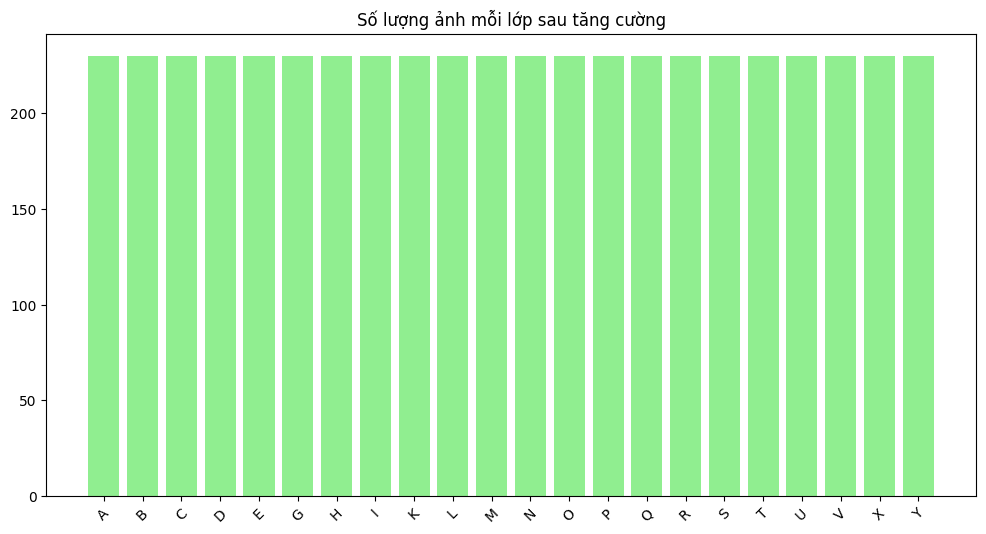

In [13]:
# Kiểm tra lại sự mất cân bằng của các lớp
class_counts = defaultdict(int)
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if os.path.isdir(person_path):
        class_counts[person] = len([f for f in os.listdir(person_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.xticks(rotation=45)
plt.title("Số lượng ảnh mỗi lớp sau tăng cường")
plt.show()

# 3. Trích xuất điểm ảnh, đặc trung bàn tay


In [14]:
# Lưu nhãn dữ liệu
dataset_path = "../dataset"
save_dir = "../keypoint"
# Lấy danh sách tên lớp (tên thư mục con) và lưu lại để dùng khi dự đoán
label_names = sorted(os.listdir(dataset_path))
np.save(os.path.join(save_dir, "label_names.npy"), label_names)

label_dict = {name: i for i, name in enumerate(label_names)}

In [15]:

import mediapipe as mp


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

label_names = sorted(os.listdir(dataset_path))
label_dict = {name: i for i, name in enumerate(label_names)}

SAVE_X, SAVE_Y = [], []

for label in label_names:
    class_path = os.path.join(dataset_path, label)
    for file in os.listdir(class_path):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f" Không đọc được ảnh: {img_path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            keypoints = []
            for lm in results.multi_hand_landmarks[0].landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            SAVE_X.append(keypoints)
            SAVE_Y.append(label)  # lưu tên lớp (chuỗi)
            print(f"   ✓ {file}")
        else:
            print(f" Không phát hiện tay trong: {file}")

X = np.array(SAVE_X)
y_labels = np.array(SAVE_Y)  # mảng chuỗi

save_path = os.path.join(save_dir, "keypoints_and_labels.npz")
np.savez(save_path, features=X, labels=y_labels)

print(f"\nĐã lưu {len(X)} mẫu keypoints và nhãn dạng chuỗi vào '{save_path}'")


 Không phát hiện tay trong: aug_0_A_156_jpg.rf.ccf545a166c6cc4dae151ff215a3b0e4.jpg
   ✓ aug_10_A_104_jpg.rf.99822fa0462978c9d63fc5ab45817234.jpg
   ✓ aug_11_A_168_jpg.rf.9cd5a49c155e744ac5e9e86fafb96f00.jpg
   ✓ aug_12_A_68_jpg.rf.1e09d706697376721b171da25fee173d.jpg
   ✓ aug_13_A_36_jpg.rf.3a3d5b5833fdb7782bd1b5183e27a54d.jpg
   ✓ aug_14_A_67_jpg.rf.0149c835f5186fed83f104752496cb25.jpg
   ✓ aug_15_A_150_jpg.rf.a1d7484b90ef8bd431f7bbb317224ab3.jpg
 Không phát hiện tay trong: aug_16_A_178_jpg.rf.f2110c8aa26afb1e3f8ba7f3a5e76472.jpg
   ✓ aug_17_A_5_jpg.rf.1e06917115979f22cd401e341de1c184.jpg
   ✓ aug_18_A_117_jpg.rf.a293dc833a6d6bb4d8608b4ba7ee4cdd.jpg
   ✓ aug_19_A_198_jpg.rf.8a6e40af2c5b51e1bec06536625d0e85.jpg
 Không phát hiện tay trong: aug_1_A_112_jpg.rf.0620909fd3c8f0cb8d00687da8591840.jpg
   ✓ aug_20_A_184_jpg.rf.af60f71edf681fef30b5a633747014aa.jpg
   ✓ aug_21_A_174_jpg.rf.beb2e01e4e2bbfa71f03a04b4dedd3f5.jpg
   ✓ aug_22_A_53_jpg.rf.4e2d6fbed67e4f3f8397c9c34c4d1971.jpg
   ✓ aug_

In [16]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Đọc dữ liệu
data = np.load("../keypoint/keypoints_and_labels.npz", allow_pickle=True)
X = data['features']
y_labels = data['labels']

print("Tổng số mẫu:", len(X))

# Tạo mapping label string -> integer
label_names = sorted(list(set(y_labels)))
label_dict = {name: i for i, name in enumerate(label_names)}

# Chuyển nhãn chuỗi thành nhãn số
y = np.array([label_dict[label] for label in y_labels])

# One-hot encoding
y_cat = to_categorical(y)

# Chia dữ liệu (stratify theo nhãn số)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# Xây mô hình
input_dim = X.shape[1]
num_classes = y_cat.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Đường dẫn lưu mô hình
model_path = "Model/keypoint_model.h5"

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print(f" Mô hình đã lưu tại: {model_path}")


Tổng số mẫu: 4623
Train: (3236, 63)
Val: (693, 63)
Test: (694, 63)


c:\Users\Loc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,966 (230.34 KB)

 Trainable params: 58,966 (230.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
 99/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1588 - loss: 2.8294

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1634 - loss: 2.8139 - val_accuracy: 0.6984 - val_loss: 1.2901
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6211 - loss: 1.2312

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6218 - loss: 1.2292 - val_accuracy: 0.8485 - val_loss: 0.5585
Epoch 3/100
 99/102 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7660 - loss: 0.7459

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7671 - loss: 0.7426 - val_accuracy: 0.9149 - val_loss: 0.3686
Epoch 4/100
 95/102 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8294 - loss: 0.5344

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8307 - loss: 0.5307 - val_accuracy: 0.9235 - val_loss: 0.3004
Epoch 5/100
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8745 - loss: 0.4134

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8747 - loss: 0.4127 - val_accuracy: 0.9408 - val_loss: 0.2410
Epoch 6/100
 98/102 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8935 - loss: 0.3673

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8939 - loss: 0.3663 - val_accuracy: 0.9639 - val_loss: 0.2106
Epoch 7/100
 99/102 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9197 - loss: 0.2859

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9198 - loss: 0.2862 - val_accuracy: 0.9668 - val_loss: 0.1649
Epoch 8/100
 92/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9150 - loss: 0.2708

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9162 - loss: 0.2697 - val_accuracy: 0.9683 - val_loss: 0.1533
Epoch 9/100
 96/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9395 - loss: 0.2271

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9398 - loss: 0.2266 - val_accuracy: 0.9553 - val_loss: 0.1505
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9366 - loss: 0.2307 - val_accuracy: 0.9596 - val_loss: 0.1549
Epoch 11/100
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9154 - loss: 0.2462

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9160 - loss: 0.2453 - val_accuracy: 0.9683 - val_loss: 0.1366
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9389 - loss: 0.2108

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9390 - loss: 0.2107 - val_accuracy: 0.9726 - val_loss: 0.1351
Epoch 13/100
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9547 - loss: 0.1681

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9548 - loss: 0.1680 - val_accuracy: 0.9740 - val_loss: 0.1087
Epoch 14/100
 96/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9606 - loss: 0.1518

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9602 - loss: 0.1525 - val_accuracy: 0.9784 - val_loss: 0.1086
Epoch 15/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9645 - loss: 0.1430 - val_accuracy: 0.9769 - val_loss: 0.1180
Epoch 16/100
 98/102 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9653 - loss: 0.1353

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9654 - loss: 0.1353 - val_accuracy: 0.9798 - val_loss: 0.1010
Epoch 17/100
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9684 - loss: 0.1268

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9683 - loss: 0.1268 - val_accuracy: 0.9784 - val_loss: 0.0939
Epoch 18/100
 99/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9586 - loss: 0.1413

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9588 - loss: 0.1408 - val_accuracy: 0.9769 - val_loss: 0.0926
Epoch 19/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9672 - loss: 0.1249 - val_accuracy: 0.9740 - val_loss: 0.1153
Epoch 20/100
 96/102 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9678 - loss: 0.1296

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9676 - loss: 0.1297 - val_accuracy: 0.9827 - val_loss: 0.0873
Epoch 21/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9670 - loss: 0.1322 - val_accuracy: 0.9668 - val_loss: 0.1129
Epoch 22/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9605 - loss: 0.1482 - val_accuracy: 0.9755 - val_loss: 0.0893
Epoch 23/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9772 - loss: 0.0952 - val_accuracy: 0.9697 - val_loss: 0.1068
Epoch 24/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9683 - loss: 0.1110 - val_accuracy: 0.9798 - val_loss: 0.0944
Epoch 25/100
 98/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9755 - loss: 0.0933

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9753 - loss: 0.0939 - val_accuracy: 0.9769 - val_loss: 0.0836
Epoch 26/100
 97/102 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9750 - loss: 0.0939

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9749 - loss: 0.0942 - val_accuracy: 0.9784 - val_loss: 0.0751
Epoch 27/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9679 - loss: 0.0979 - val_accuracy: 0.9798 - val_loss: 0.0800
Epoch 28/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9603 - loss: 0.1478 - val_accuracy: 0.9812 - val_loss: 0.0796
Epoch 29/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9742 - loss: 0.1027 - val_accuracy: 0.9798 - val_loss: 0.0788
Epoch 30/100
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9754 - loss: 0.0917

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9754 - loss: 0.0917 - val_accuracy: 0.9841 - val_loss: 0.0699
Epoch 31/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9803 - loss: 0.0757 - val_accuracy: 0.9812 - val_loss: 0.0740
Epoch 32/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9756 - loss: 0.0869 - val_accuracy: 0.9827 - val_loss: 0.0764
Epoch 33/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9795 - loss: 0.0876 - val_accuracy: 0.9740 - val_loss: 0.0881
Epoch 34/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9798 - loss: 0.0745 - val_accuracy: 0.9870 - val_loss: 0.0766
Epoch 35/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9805 - loss: 0.0743 - val_accuracy: 0.9812 - val_loss: 0.0793
Epoch 36/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9750 - loss: 0.0870 - val_accuracy: 0.9812 - val_loss: 0.0765
Epoch 37/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9753 - loss: 0.0906 - val_acc

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9830 - loss: 0.0640 - val_accuracy: 0.9870 - val_loss: 0.0629
Epoch 39/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9354 - loss: 0.2580 - val_accuracy: 0.9812 - val_loss: 0.0666
Epoch 40/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9816 - loss: 0.0770 - val_accuracy: 0.9856 - val_loss: 0.0664
Epoch 41/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9855 - loss: 0.0543 - val_accuracy: 0.9841 - val_loss: 0.0656
Epoch 42/100
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9776 - loss: 0.0765

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9775 - loss: 0.0767 - val_accuracy: 0.9856 - val_loss: 0.0618
Epoch 43/100
 98/102 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9847 - loss: 0.0569

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9845 - loss: 0.0573 - val_accuracy: 0.9885 - val_loss: 0.0546
Epoch 44/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9802 - loss: 0.0716 - val_accuracy: 0.9856 - val_loss: 0.0610
Epoch 45/100
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9841 - loss: 0.0640

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9840 - loss: 0.0642 - val_accuracy: 0.9870 - val_loss: 0.0486
Epoch 46/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9832 - loss: 0.0619 - val_accuracy: 0.9841 - val_loss: 0.0521
Epoch 47/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9818 - loss: 0.0559 - val_accuracy: 0.9885 - val_loss: 0.0726
Epoch 48/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9747 - loss: 0.0848 - val_accuracy: 0.9856 - val_loss: 0.0514
Epoch 49/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9813 - loss: 0.0696 - val_accuracy: 0.9856 - val_loss: 0.0589
Epoch 50/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9783 - loss: 0.0671 - val_accuracy: 0.9870 - val_loss: 0.0514
Epoch 51/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9841 - loss: 0.0597 - val_accuracy: 0.9885 - val_loss: 0.0610
Epoch 52/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9831 - loss: 0.0575 - val_a

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9835 - loss: 0.0635 - val_accuracy: 0.9885 - val_loss: 0.0453
Epoch 54/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9730 - loss: 0.0959 - val_accuracy: 0.9856 - val_loss: 0.0607
Epoch 55/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9864 - loss: 0.0538 - val_accuracy: 0.9841 - val_loss: 0.0500
Epoch 56/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9790 - loss: 0.0651 - val_accuracy: 0.9870 - val_loss: 0.0477
Epoch 57/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9881 - loss: 0.0421 - val_accuracy: 0.9841 - val_loss: 0.0588
Epoch 58/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9843 - loss: 0.0587 - val_accuracy: 0.9870 - val_loss: 0.0697
Epoch 59/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9823 - loss: 0.0649 - val_accuracy: 0.9870 - val_loss: 0.0559
Epoch 60/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9853 - loss: 0.0536 - val_accu

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9901 - loss: 0.0372 - val_accuracy: 0.9885 - val_loss: 0.0403
Epoch 63/100
 98/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9861 - loss: 0.0496

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9859 - loss: 0.0502 - val_accuracy: 0.9885 - val_loss: 0.0392
Epoch 64/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9841 - loss: 0.0489 - val_accuracy: 0.9827 - val_loss: 0.0512
Epoch 65/100
 99/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9702 - loss: 0.0922

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9706 - loss: 0.0913 - val_accuracy: 0.9913 - val_loss: 0.0339
Epoch 66/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9886 - loss: 0.0440 - val_accuracy: 0.9870 - val_loss: 0.0461
Epoch 67/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9843 - loss: 0.0501 - val_accuracy: 0.9870 - val_loss: 0.0437
Epoch 68/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9818 - loss: 0.0680 - val_accuracy: 0.9827 - val_loss: 0.0576
Epoch 69/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9769 - loss: 0.0649 - val_accuracy: 0.9870 - val_loss: 0.0477
Epoch 70/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9892 - loss: 0.0342 - val_accuracy: 0.9856 - val_loss: 0.0491
Epoch 71/100
 99/102 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9915 - loss: 0.0417

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9914 - loss: 0.0417 - val_accuracy: 0.9899 - val_loss: 0.0326
Epoch 72/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9861 - loss: 0.0426 - val_accuracy: 0.9870 - val_loss: 0.0437
Epoch 73/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9887 - loss: 0.0373 - val_accuracy: 0.9913 - val_loss: 0.0422
Epoch 74/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9831 - loss: 0.0537 - val_accuracy: 0.9899 - val_loss: 0.0432
Epoch 75/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9879 - loss: 0.0450 - val_accuracy: 0.9885 - val_loss: 0.0427
Epoch 76/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9843 - loss: 0.0461 - val_accuracy: 0.9841 - val_loss: 0.0536
Epoch 77/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9878 - loss: 0.0385 - val_accuracy: 0.9913 - val_loss: 0.0460
Epoch 78/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9879 - loss: 0.0346 - val_acc

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9867 - loss: 0.0472 - val_accuracy: 0.9913 - val_loss: 0.0313
Epoch 80/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9830 - loss: 0.0471 - val_accuracy: 0.9899 - val_loss: 0.0328
Epoch 81/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9828 - loss: 0.0577 - val_accuracy: 0.9856 - val_loss: 0.0461
Epoch 82/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9882 - loss: 0.0399 - val_accuracy: 0.9870 - val_loss: 0.0373
Epoch 83/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9897 - loss: 0.0357 - val_accuracy: 0.9899 - val_loss: 0.0325
Epoch 84/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9869 - loss: 0.0464 - val_accuracy: 0.9856 - val_loss: 0.0427
Epoch 85/100
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9860 - loss: 0.0484

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9861 - loss: 0.0482 - val_accuracy: 0.9928 - val_loss: 0.0297
Epoch 86/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9903 - loss: 0.0343 - val_accuracy: 0.9899 - val_loss: 0.0429
Epoch 87/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9885 - loss: 0.0317 - val_accuracy: 0.9885 - val_loss: 0.0376
Epoch 88/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9859 - loss: 0.0402 - val_accuracy: 0.9928 - val_loss: 0.0398
Epoch 89/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9920 - loss: 0.0281 - val_accuracy: 0.9913 - val_loss: 0.0340
Epoch 90/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9683 - loss: 0.1242 - val_accuracy: 0.9899 - val_loss: 0.0348
Epoch 91/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9844 - loss: 0.0430 - val_accuracy: 0.9899 - val_loss: 0.0427
Epoch 92/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9784 - loss: 0.0586 - val_accu